# 1 Import libraries and load data

## 1.1 Import libaries

In [1]:
import glob
import time as systime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
font = {'family' : 'Arial',
        'size'   : 9}
plt.rc('font', **font)
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

parent_dir = r'U:/Vehicle Coordination Yiru'

## 1.2 Global functions

In [2]:
# Define functions
def determine_conflicts(samples):
    samples['conflict_1'] = (samples['ttc']<3)
    samples['conflict_2'] = False
    samples.loc[(samples['speed']>=20)&(samples['ttc']<4), 'conflict_2'] = True
    samples.loc[(samples['speed']>=8)&(samples['speed']<20)&(samples['ttc']<3), 'conflict_2'] = True
    samples.loc[(samples['speed']>=3)&(samples['speed']<8)&(samples['ttc']<2), 'conflict_2'] = True
    samples.loc[(samples['speed']<3)&(samples['s']/samples['speed']<1), 'conflict_2'] = True

    return samples


def Grouping(samples, vehnum):
    samples = samples.sort_values(by='v')
    samples['round_v'] = np.round(samples.v,1)
    groups = samples.groupby('round_v').v.count()
    try:
        threshold = groups[groups>=vehnum].index[-1]
        sample1 = []
        for roundv in samples[samples.round_v<=threshold].round_v.unique():
            sample1.append(samples[samples.round_v==roundv])
        sample1 = pd.concat(sample1)
        print('--- '+str(roundv)+' ----')
    except:
        threshold = 0
        sample1 = samples[samples.round_v<0].copy()
    sample2 = samples[samples.round_v>threshold].copy()
    sample2['round_v'] = np.arange(len(sample2))//vehnum
    sample2['round_v'] = (np.round(sample2.groupby('round_v').v.mean(),1)).reindex(sample2.round_v).values
    samples = pd.concat((sample1, sample2))

    return samples

# 2 highD

In [3]:
## Load data
data_all = []
for loc in tqdm(['highD_0'+str(i) for i in range(6,0,-1)]):
    data = pd.read_hdf(parent_dir + '/OutputData/ADAS/FCW/data/highD/'+loc+'.h5', key='data')
    data_all.append(data)
data_all = pd.concat(data_all).reset_index(drop=True)

data_all['s'] = abs(data_all['pre_position'] - data_all['position']) - data_all['pre_length'] # net distance
data_all['v'] = data_all['speed'] - data_all['pre_speed']
samples_highD = data_all[(data_all['s']>0)&(data_all['v']>0)]
samples_highD.to_hdf(parent_dir + '/OutputData/ADAS/FCW/samples/samples_highD.h5', key='data', mode='w')

100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


In [4]:
## Determine conflicts
samples_highD['ttc'] = samples_highD['s']/samples_highD['v']
print('The percentage of TTCs that are inf: ', np.isinf(samples_highD['ttc']).sum()/len(samples_highD))
samples_highD = determine_conflicts(samples_highD.copy())

The percentage of TTCs that are inf:  0.0


(0.0, 20000.0)

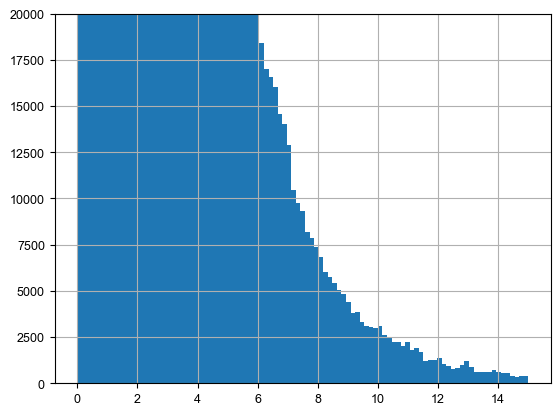

In [7]:
samples_highD.v.hist(bins=np.linspace(0,15,100))
plt.ylim(0,20000)

In [11]:
## Sample data
samples = Grouping(samples_highD, 15000)
samples = samples.sort_values(by='v').reset_index(drop=True)
print('--- '+str(len(samples[samples.round_v<=10].round_v.unique()))+' ----')
samples[['s','v','conflict_1','conflict_2']].to_hdf(parent_dir + '/OutputData/ADAS/FCW/samples/samples_toinfer_highD.h5', key='samples')

--- 5.6 ----
--- 76 ----


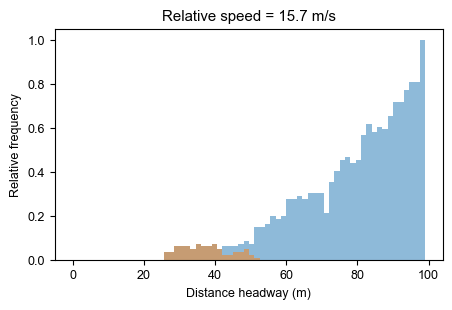

In [12]:
samples = pd.read_hdf(parent_dir + '/OutputData/ADAS/FCW/samples/samples_toinfer_highD.h5', key='samples')

for speed in samples.round_v.unique():
    cfdata = samples[samples.round_v==speed]
    fig, ax = plt.subplots(figsize=(5,3))

    freq1, bins = np.histogram(cfdata.s, bins=np.arange(0,100,1.5))
    ax.bar((bins[1:]+bins[:-1])/2, freq1/freq1.max(), width=1.5, alpha=0.5)

    cfdata = cfdata[cfdata['conflict_2']]
    freq2, bins = np.histogram(cfdata.s, bins=np.arange(0,100,1.5))
    ax.bar((bins[1:]+bins[:-1])/2, freq2/freq1.max(), width=1.5, alpha=0.5)
    
    ax.set_title('Relative speed = %.1f m/s'%speed)
    ax.set_xlabel('Distance headway (m)')
    ax.set_ylabel('Relative frequency')
    clear_output(wait=True)
    display(fig)
    systime.sleep(0.1)
    plt.close()

# 3 FreewayB

In [13]:
## Load data
data_all = []
for loc in tqdm(['FreewayB_0'+str(i) for i in range(7,0,-1)]):
    data = pd.read_hdf(parent_dir + '/OutputData/ADAS/FCW/data/FreewayB/'+loc+'.h5', key='data')
    data_all.append(data)
data_all = pd.concat(data_all).reset_index(drop=True)

data_all['s'] = abs(data_all['pre_position'] - data_all['position']) - data_all['pre_length'] # net distance
data_all['v'] = data_all['speed'] - data_all['pre_speed']
samples_FreewayB = data_all[(data_all['s']>0)&(data_all['v']>0)]
samples_FreewayB.to_hdf(parent_dir + '/OutputData/ADAS/FCW/samples/samples_FreewayB.h5', key='data', mode='w')

100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


In [14]:
## Determine conflicts
samples_FreewayB['ttc'] = samples_FreewayB['s']/samples_FreewayB['v']
print('The percentage of TTCs that are inf: ', np.isinf(samples_FreewayB['ttc']).sum()/len(samples_FreewayB))
samples_FreewayB = determine_conflicts(samples_FreewayB.copy())

The percentage of TTCs that are inf:  0.0


(0.0, 20000.0)

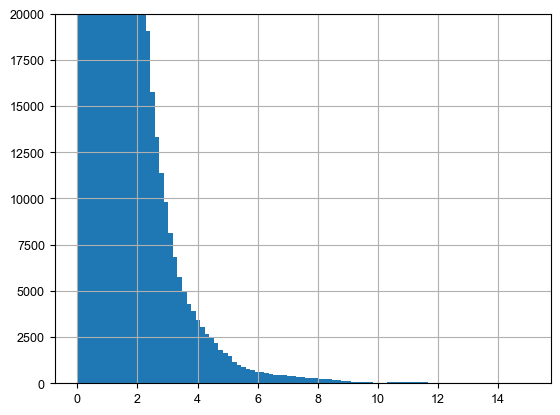

In [15]:
samples_FreewayB.v.hist(bins=np.linspace(0,15,100))
plt.ylim(0,20000)

In [30]:
## Sample data
samples = Grouping(samples_FreewayB, 7500)
samples = samples.sort_values(by='v').reset_index(drop=True)
print('--- '+str(len(samples[samples.round_v<=10].round_v.unique()))+' ----')
# samples[['s','v','conflict_1','conflict_2']].to_hdf(parent_dir + '/OutputData/ADAS/FCW/samples/samples_toinfer_FreewayB.h5', key='samples')

--- 2.8 ----
--- 40 ----


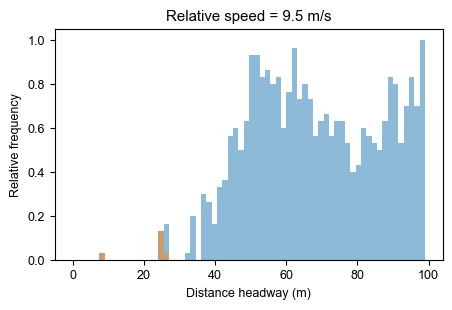

In [31]:
# samples = pd.read_hdf(parent_dir + '/OutputData/ADAS/FCW/samples/samples_toinfer_FreewayB.h5', key='samples')

for speed in samples.round_v.unique():
    cfdata = samples[samples.round_v==speed]
    fig, ax = plt.subplots(figsize=(5,3))

    freq1, bins = np.histogram(cfdata.s, bins=np.arange(0,100,1.5))
    ax.bar((bins[1:]+bins[:-1])/2, freq1/freq1.max(), width=1.5, alpha=0.5)

    cfdata = cfdata[cfdata['conflict_1']]
    freq2, bins = np.histogram(cfdata.s, bins=np.arange(0,100,1.5))
    ax.bar((bins[1:]+bins[:-1])/2, freq2/freq1.max(), width=1.5, alpha=0.5)
    
    ax.set_title('Relative speed = %.1f m/s'%speed)
    ax.set_xlabel('Distance headway (m)')
    ax.set_ylabel('Relative frequency')
    clear_output(wait=True)
    display(fig)
    systime.sleep(0.1)
    plt.close()